In [1]:
import numpy as np
from matplotlib import pyplot as plt

from src.channel_blocks import ChannelBlocks
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier
from src.visualizer import Visualizer

# Channel Simulation
here starts the actual channel simulator code.

we will demonstrate the following block diagram


In [10]:
cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=0.001,
                      channel_func=SplitStepFourier(),
                      verbose=False)
cb = ChannelBlocks(cs.verbose)

In [11]:
cb.verbose = False
cs.x[0] = cb.generate_message(cs.length_of_msg, cs.sps)
cs.x[1], cs.modem = cb.modulate(cs.x[0], cs.m_qam)
cs.x[2] = cb.over_sample(cs.x[1], cs.over_sampling)
cs.x[3], cs.L_rrc, cs.h_rrc = cb.pulse_shape(cs.x[2], cs.roll_off,cs.over_sampling,cs.Ts)
cs.x[4] = cb.pre_equalize(cs.x[3],cs.normalization_factor)

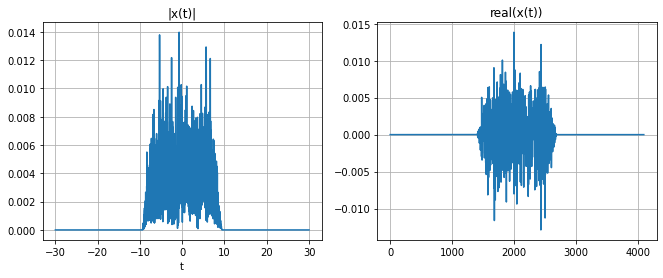

length of INFT(x) = 4096


In [12]:
cb.verbose = True
cs.N_xi, cs.N_time, cs.tvec, cs.xivec, cs.BW = cb.gen_nft_params(cs.x[4],cs.Tmax)
cs.x[5] = cb.inft(cs.x[4],cs.tvec,cs.xivec)

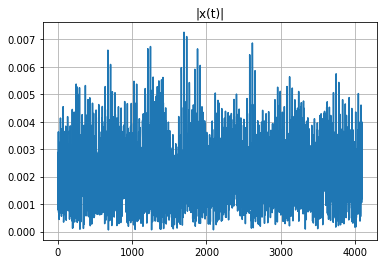

In [13]:
cs.channel_func = SplitStepFourier(
    alpha=0,
    b2=-20e-27,
    gamma=0.003,
    to=125e-12,
    steps=np.arange(0.1,1.51,0.1),
    dt=1e-12,
    h=5000
)
cs.x[6] = cb.channel(cs.x[5],cs.channel_func)

## 7) NFT

In [ ]:
cs.x[7] = cb.nft(cs.x[6],cs.tvec,cs.xivec,cs.BW,cs.N_xi,cs.L_rrc,cs.x[4])

## 8) Equalizer


*   de-normalize
*   channel equalizer (nothing)



In [ ]:
cs.x[8] = cb.equalizer(cs.x[7], cs.normalization_factor)

## 9) Match Filter
convolve again with the rrc filter and sample at the over sampling period

In [ ]:
cs.x[9] = cb.match_filter(cs.x[8],cs.h_rrc,cs.L_rrc,cs.over_sampling,cs.m_qam,cs.sps)

## 10) Demodulation

In [ ]:
cs.x[10] = cb.demodulate(cs.x[9],cs.modem, cs.length_of_msg)
ber, num_errors = cb.calc_ber(cs.x[0],cs.x[10],cs.length_of_msg,cs.sps)